# Experiment: finding drive frequency for different subharmonics


in this experiment, we are numerically trying to find the subharmonic driving frequencies (w_d) for N=3,4,5 (N=2 is already provided) that result in rabi oscillations of a spin-1/2. to see how we find w_d, refer to find-subharmonic-freq.py. in short, we start with an initial "guess" of the subharmonic frequency, which is w_0 / N, where w_0 is the harmonic frequency. then, we search for a small range around said estimate, and look for the value that gives the lowest <sz> (below the acceptable threshold of -0.9) that successfully flips the spin to the down state.

why do we need to search for range and cannot take w_0 / N as the Nth subharmonic? because, in actuality, the subharmonic frequency is actually w_d = w_0 / N +- V, where V is defined by the bloch steigart shift (caused by counter rotating part of the driving). furthermore, we use a strong driving regime. this is because w_d is "easier" to find/approximate: with weak driving, although it would be easier to predict the bss component, the precision of the calculated driving frequency would need to be much higher; even being off by a very small fraction would not yield results. also, we would need longer simulation times (simulation time vs precision trade-off).

In [2]:
import numpy as np
from qutip import basis
from scipy.optimize import minimize_scalar
from matplotlib import pyplot as plt
from qutip import sigmax, sigmay, sigmaz, sigmam, mesolve, mcsolve

def qubit_integrate_labframe(omega_0, omega_d, rabi, theta,psi0, solver, phi = 0, g1 = 0, g2 = 0, tlist=np.linspace(0,5000,10000)):

    H0 = (omega_0/2) * sigmaz()
    H1 = 2 * rabi * np.sin(theta) * sigmax()
    H2 = 2 * rabi * np.cos(theta) * sigmaz()
    
    def H1_coeff(t, args):
        return np.cos(omega_d*t+phi)
        
    def H2_coeff(t, args):
        return np.cos(omega_d*t+phi)
    
    # collapse operators
    c_ops = []

    if g1 > 0.0:
        c_ops.append(np.sqrt(g1) * sigmam())

    if g2 > 0.0:
        c_ops.append(np.sqrt(g2) * sigmaz())

    e_ops = [sigmax(), sigmay(), sigmaz()]
    
    H = [H0, [H1,H1_coeff],  [H2,H2_coeff]]
    
    if solver == "me":
        output = mesolve(H, psi0, tlist, c_ops, e_ops)  
    #elif solver == "es":
    #    output = essolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "mc":
        ntraj = 250
        output = mcsolve(H, psi0, tlist, ntraj, c_ops, e_ops)  
    else:
        raise ValueError("unknown solver")
        
    return output.expect[0], output.expect[1], output.expect[2]

the method below plots the progression of <sz> over time at the subharmonic frequency. N is the subharmonic number, rabi the driving amplitude, theta the drive angle, omega_d the subharmonic driving frequency, t_max the end of the time range, and samples the number of evenly spaced values between [0, t_max] that we calculate <sz> for.

In [3]:
def find_and_plot_subharmonic(N, rabi, theta, omega_d, t_max=150000, samples=10000):
    omega_0 = 1.0 * np.pi   # resonance frequency
    g2 = 0.0
    g1 = 0.0
    psi0 = basis(2,0)
    tlist = np.linspace(0, t_max, samples)
    phi = 0

    _, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0, "me", phi, g1, g2, tlist)

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(tlist, np.real(sz_brwa_d), 'g')
    ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(f"N={N} Resonance at w_d = {omega_d/np.pi:.10f}π")

unlike N=3, that has a smooth sine curve, N=4 and 5 (when zoomed in to a smaller time range), appear to have some jitter. For N=3, the oscillation period is quite long, for t_max=10,000, we only see approx. 2.5 oscillations. For lower subharmonics, however, the period is much smaller- see the difference between t_max=1000 and t_max=300 for N=4. Thus, when we observe the oscillations over a smaller time frame, this "noisiness" is more visible.

thus, to make the spin flip more visible, we can, after finding w_d, only plot the points where we expect the peaks to be using the function below.

In [33]:
def stroboscopic_plot(N, rabi, theta, omega_d, t_max=300, samples=1000):
    omega_0 = 1.0 * np.pi   # resonance frequency
    g2 = 0.0
    g1 = 0.0
    psi0 = basis(2,0)
    tlist = np.linspace(0, t_max, samples)
    phi = 0

    drive_period = (2 * np.pi) / omega_d
    t_strobe = np.arange(0, t_max, drive_period)


    _, _, sz_strobe = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0, "me", 0, 0, 0, t_strobe)

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(t_strobe, np.real(sz_strobe), 'g-o', markersize=2, label="Stroboscopic Sz")
    ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
    ax.set_title(f"Cleaned N={N} Dynamics (Stroboscopic)")
    plt.show()

## N = 3

this one uses weak driving

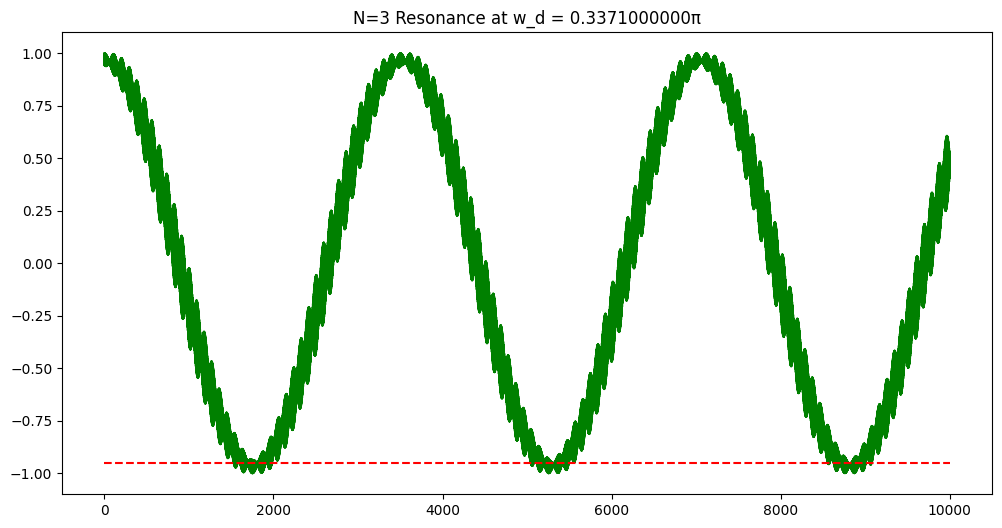

In [9]:
find_and_plot_subharmonic(3, 0.05 * np.pi, 0.5 * np.pi, 0.3371 * np.pi, t_max=10000)

## N = 4

t_max=1000

/Users/pmeswani/Documents/qdqc/venv/lib/python3.13/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


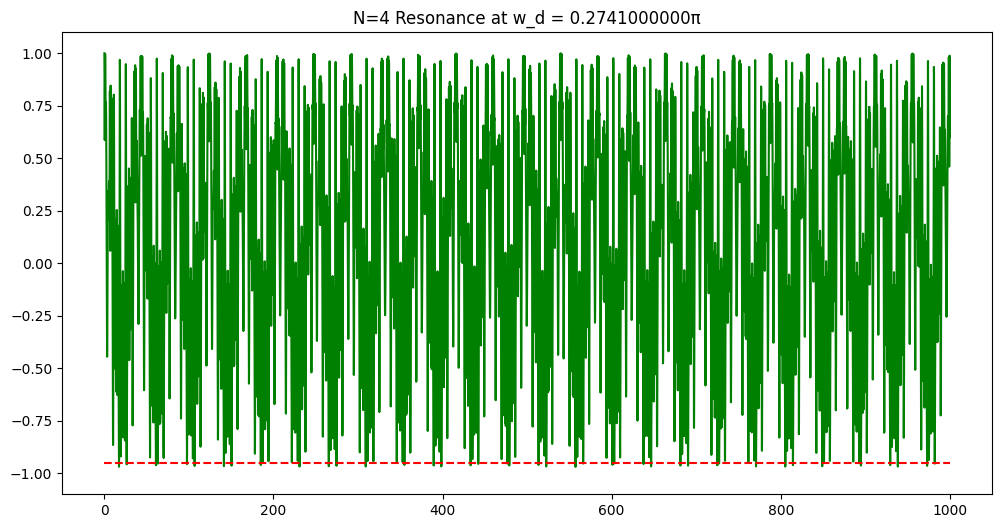

In [35]:
find_and_plot_subharmonic(4, 0.27 * np.pi / np.sin(0.25 * np.pi), 0.25 * np.pi, 0.2741000000000000103028696685214526951313018798828125 * np.pi, t_max=1000)

t_max=300

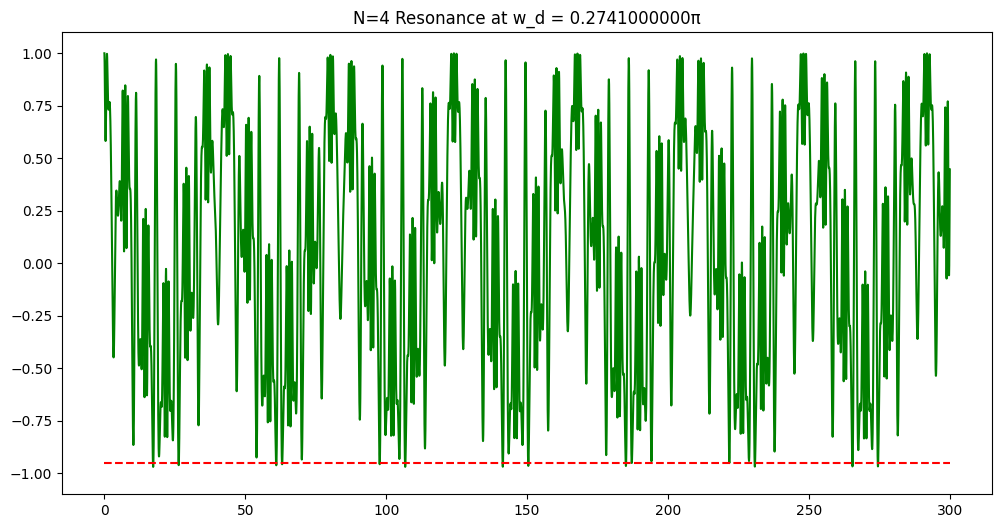

In [24]:
find_and_plot_subharmonic(4, 0.27 * np.pi / np.sin(0.25 * np.pi), 0.25 * np.pi, 0.2741000000000000103028696685214526951313018798828125 * np.pi, t_max=300)

## N = 5

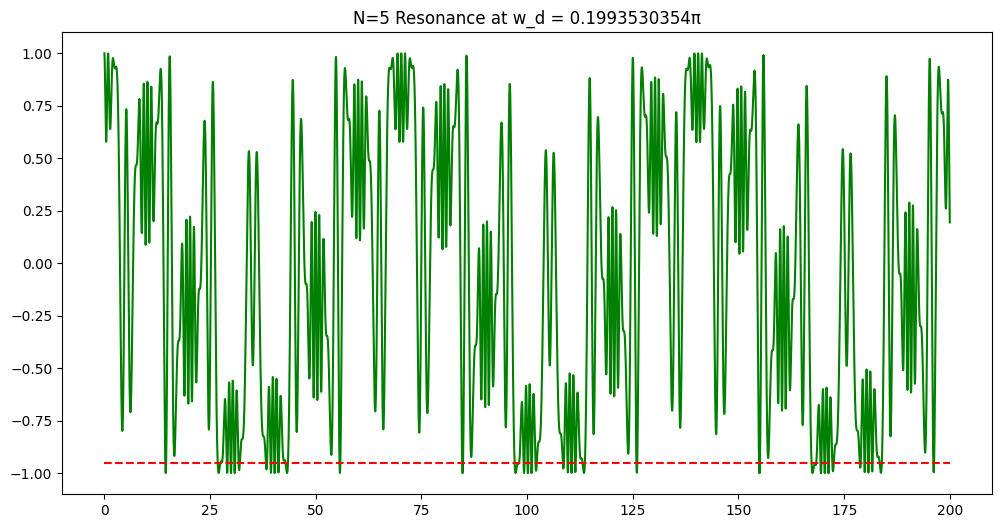

In [34]:
find_and_plot_subharmonic(5, 0.27 * np.pi / np.sin(0.25 * np.pi), 0.25 * np.pi, 0.199353035400046230130044477846240624785423278808593750 * np.pi, t_max=200)

only taking samples around when the spin is at its peaks 

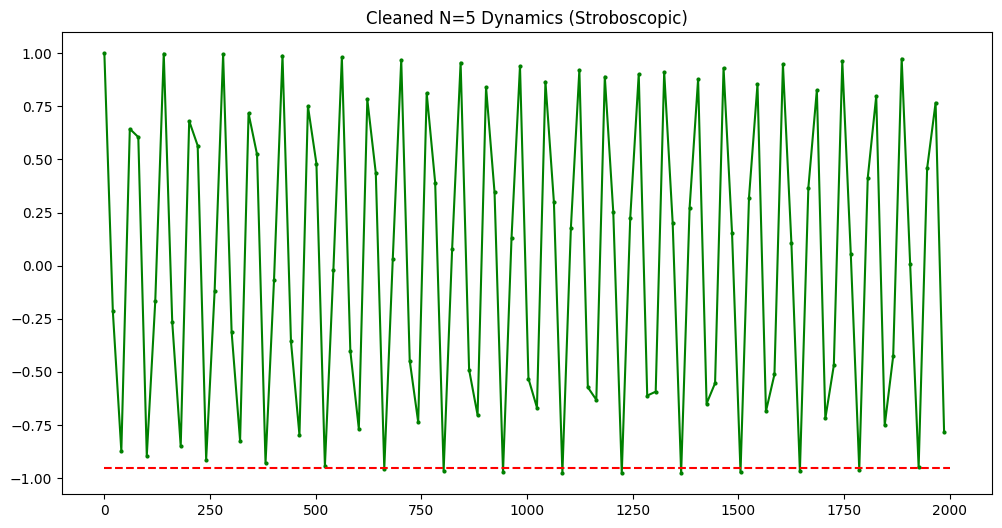

In [23]:
stroboscopic_plot(5, 0.27 * np.pi / np.sin(0.25 * np.pi), 0.25 * np.pi, 0.199353035400046230130044477846240624785423278808593750 * np.pi, t_max=2000)

maybe will try: N=4 with weak driving